



# Extension 01 // Convolutional Neural Network 

In [1]:
# set Hyperparameters 
epochs = 10

## Part ( i ) // Baseline Initial Machine Learning Algorithm on Dataset I: 
## Vanilla Neural Network

The base strategy we are going to start with is Neural Networks. This topic was was covered in the week 8. In this first section I will include the code given in homework 8. The performance will give us a benchmark we can work from. 

Our extension to the code in homework 8 will be to add a convolutional layers to the neural network. First, we will use a PyTorch implementation. Then, we will write our own implementation. 

Here is the Neural Network implemented in homework 8. 

### The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [2]:
# Import Libraries
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, Legend
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)
[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


<Figure size 432x288 with 0 Axes>

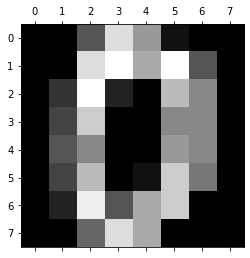

In [3]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

### 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [4]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

### 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [5]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

### 3) Setting up the output layer

### One hot encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.


In [6]:
print('/test/test_{:0>3f}'.format(np.around(9.7748848488448, decimals=4)))

/test/test_9.774900


In [7]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [8]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [9]:
print(y_train[0:4])
print(y_v_train[0:4])

[6 4 8 7]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


### 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [10]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [11]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [12]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

### Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [13]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        # import pdb; pdb.set_trace()
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

### Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [14]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

### The Back Propagation Algorithm


In [15]:
def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

def train_nn(nn_structure, X_train, y_train, X_test, y_test, iter_num=100, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y_train)
    avg_cost_func = []

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []
    train_examples = len(y_train)
    test_examples = len(y_test)

    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Epoch {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0

        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0


        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X_train[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y_train[i,:], a[l], z[l])
                    loss_train += np.linalg.norm((y_train[i,:]-a[l]))
                    if np.argmax(a[len(nn_structure)]) == np.argmax(y_v_train[i]):
                      acc_train += 1.0
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        
        # Test model

        # get y prediction
        # y_pred = predict_y(W, b, X_test, 3)
        
        for i in range(test_examples):
         
            a, z = feed_forward(X_test[i, :], W, b)
            # calculate loss
            loss_test += np.linalg.norm((y_test[i,:]-a[len(nn_structure)]))
            # calculate accuracy
            if np.argmax(a[len(nn_structure)]) == np.argmax(y_v_test[i]):
                acc_test += 1
            
        # complete the average cost calculation
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        cnt += 1
    return W, b, (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)




### Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [16]:
nn_structure = [64, 30, 10]
    
# train the NN
%time W, b, result_cnn_vanilla = train_nn(nn_structure, X_train, y_v_train, X_test, y_v_test, epochs, 0.25)

Starting gradient descent for 10 iterations
Epoch 0 of 10
CPU times: user 1.76 s, sys: 7.23 ms, total: 1.76 s
Wall time: 1.76 s


### Plotting the learning curve


In [41]:
def plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq, filename):
    print('The test set prediction accuracy is {}%'.format(acc_test_seq[-1] * 100))
    # import pdb; pdb.set_trace()
    source = ColumnDataSource(data={
        'epoch'            : range(1, len(loss_test_seq) + 1),
        'train_loss'    : loss_train_seq,
        'test_loss'        :  loss_test_seq,
    })
    our_title = filename + ' Loss'
    p = figure(title=our_title, plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_loss', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_loss', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "top_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Loss' 

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Loss', '@train_loss{0.000 a}'),
                  ('Test Loss', '@test_loss{0.000 a}'),
        ],

        mode='mouse'
    ))
    fullname = "results/" + filename + "-loss.html"
    output_file(fullname)
    save(p)

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_train_seq) + 1),
        'train_acc'    : np.array(acc_train_seq),
        'test_acc'        :  np.array(acc_test_seq),
    })

    our_title = filename + ' Accuracy'
    p = figure(title=our_title, plot_width=400, plot_height=400)

    p.line(x='epoch', y='train_acc', color='#329fe3', line_alpha=0.8 , line_width=2, legend_label="Train", source=source)
    p.line(x='epoch', y='test_acc', color='#e33270', line_alpha=0.8, line_width=2, legend_label="Test", source=source)
    p.legend.location = "bottom_right"
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy' 
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')

    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('Training Accuracy', '@{train_acc}{%0.2f}'),
                  ('Test Accuracy', '@{test_acc}{%0.2f}'),
        ],

        mode='mouse'
    ))
    fullname = "results/" + filename + "-accuracy.html"
    output_file(fullname)
    save(p)

In [42]:
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_cnn_vanilla

plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq, "Baseline")


The test set prediction accuracy is 8.484005563282336%


### 6) End of Part A

Let us see if we can make an improvement using an extension. 

## Part ( ii ) // Convolutional Neural Network Extension Using Library on Dataset II

We will be using the function:

**torch.nn.Conv2d**(in_channels, out_channels, kernel_size, stride, padding) – applies convolution

The function applies a 2D convolution over an input signal composed of several input planes. 

In the simplext case, the output values of the layer with input size 
$ (N,C_{in},H,W) $ and output $(N,C_{out},H_{out},W_{out})$ can be precesely described as: 

$$ out(N_i,C_{out_j}=bias(C_{out_j})+\Sigma^{C_{in}-1}_{k=0} weight(C_{out_j},k)\star input(N_i,k)$$

were $\star$ is the valid 2D cross-correlation operator, $N$ is the batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels. 

The documentation is online [here](https://pytorch.org/docs/stable/nn.html#conv2d).


### 1) First, we import the library including torch

In [30]:
# Import modules
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from bokeh.plotting import figure, output_file, show, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
output_notebook()


Loading BokehJS ...

### 2) Create a custom Dataset class to manage the creation, incrementing, formatting, and calling of items. 

In [20]:

class MNISTDataset(Dataset):
    def __init__(self, data, label):
        self.data = data.reshape((-1,8,8,1))
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = self.data[item].transpose((2, 0, 1))
        image = torch.from_numpy(image)
        target = self.label[item]
        target = torch.from_numpy(target)
        return (image, target)

### 3) Create a child class of the nn.Module. This will establish the functional architecture of our neural network model. 

In [21]:

class MNIST(nn.Module):

    # Our batch shape for input x is (1, 8, 8)

    def __init__(self):
        super(MNIST, self).__init__()

        # Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        # self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(18 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):

        # Activation of the first convolution
        # Size changes from (1, 8, 8) to (18, 8, 8)
        x = F.relu(self.conv1(x))

        # x = self.pool(x)

        # Reshape data to input to the input layer of the neural net
        # Size changes from (18, 16, 16) to (1, 1152)
        x = x.view(-1, 18 * 8 * 8)

        # Computes the activation of the first fully connected layer
        # Size changes from (1, 1152) to (1, 64)
        x = torch.sigmoid(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x


### 4) We will need a helper function to check the accuracy of our model's predictions. 

In [22]:
def scorecard(output, labels):
    score = 0
    score = np.where(np.argmax(output, axis=1) == np.argmax(labels, axis=1), 1, 0)
    # for i in range(len(output)):
    #     if np.argmax(output[i,:], axis=1) == np.argmax(labels[i,:], axis=1):
    #         score += 1
    score = np.sum(score)
    return score

### 5) Define the training function

In [23]:

def trainModel(model, batch_size, num_epochs, learning_rate):
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", num_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)

    digits = load_digits()
    X = digits.data
    y = digits.target

    X_scale = StandardScaler()
    X = X_scale.fit_transform(digits.data)

    # Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    def convert_y_to_vect(y):
        y_vect = np.zeros((len(y), 10))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    # convert digits to vectors
    y_v_train = convert_y_to_vect(y_train)
    y_v_test = convert_y_to_vect(y_test)

    train_dataset = MNISTDataset(X_train, y_v_train)
    test_dataset = MNISTDataset(X_test, y_v_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    mean, std = (0.5,), (0.5,)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model = model.double()

    loss_train_seq = []
    loss_test_seq = []
    acc_train_seq = []
    acc_test_seq = []

    for i in range(num_epochs):
        loss_train = 0.0
        loss_test = 0.0
        acc_train = 0.0
        acc_test = 0.0
        train_examples = 0
        test_examples = 0

        for j, (images, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            acc_train += scorecard(output.detach().numpy(), labels.detach().numpy())
            train_examples += len(labels)
            loss_train += loss.detach().numpy()
            loss.backward()
            optimizer.step()


        for images, labels in test_loader:

            with torch.no_grad():
                output = model(images)

                loss = criterion(output, labels)
                loss_test += loss.detach().numpy()
                acc_test += scorecard(output.detach().numpy(), labels.detach().numpy())
                test_examples += len(labels)
        loss_train_seq.append(loss_train / train_examples)
        loss_test_seq.append(loss_test / test_examples)
        acc_train_seq.append(acc_train / train_examples)
        acc_test_seq.append(acc_test / test_examples)
        print('Epoch {} with test loss {} and test accuracy {}\n\n'.format(i, (loss_test / test_examples),(acc_test / test_examples) ))

    return (loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)


### 6) Set the hyperparameters, create the model, and train the model

In [24]:
batch_size = 1
learning_rate = 0.01
num_epochs = epochs

model = MNIST()

%time result_cnn_pytorch = trainModel(model, batch_size, num_epochs, learning_rate)
loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq = result_cnn_pytorch

===== HYPERPARAMETERS =====
batch_size= 1
epochs= 10
learning_rate= 0.01
Epoch 0 with test loss 5.851180906071008 and test accuracy 0.7872044506258693


Epoch 1 with test loss 5.848346076357665 and test accuracy 0.8803894297635605


Epoch 2 with test loss 5.847077340008874 and test accuracy 0.9207232267037552


Epoch 3 with test loss 5.846266286179737 and test accuracy 0.9388038942976356


Epoch 4 with test loss 5.845681782625536 and test accuracy 0.952712100139082


Epoch 5 with test loss 5.845237252079421 and test accuracy 0.9554937413073713


Epoch 6 with test loss 5.844886144779089 and test accuracy 0.9568845618915159


Epoch 7 with test loss 5.844600254664653 and test accuracy 0.9638386648122392


Epoch 8 with test loss 5.84436146199944 and test accuracy 0.9652294853963839


Epoch 9 with test loss 5.844158008753793 and test accuracy 0.9666203059805285


CPU times: user 2min 49s, sys: 16.9 s, total: 3min 6s
Wall time: 30.8 s


### 7) Visualize the results

In [25]:


plot_results(loss_train_seq, loss_test_seq, acc_train_seq, acc_test_seq)

The test set prediction accuracy is 96.66203059805285%


## Compare Part ( i ) and ( ii ) on Dataset I

In [43]:
def plot_results_compare(result_cnn_vanilla, result_cnn_pytorch):

    loss_train_van, loss_test_van, acc_train_van, acc_test_van = result_cnn_vanilla
    loss_train_torch, loss_test_torch, acc_train_torch, acc_test_torch = result_cnn_pytorch

    source = ColumnDataSource(data={
        'epoch'            : range(1, len(acc_test_van) + 1),
        'test_acc_van'        :  np.array(acc_test_van),
        'test_acc_torch'        :  np.array(acc_test_torch),
    })

    p = figure(title='No CNN and PyTorch CNN Accuracy', plot_width=600, plot_height=400)

    l_van = p.line(x='epoch', y='test_acc_van', color='#329fe3', line_alpha=0.8 , line_width=2, source=source)
    l_torch = p.line(x='epoch', y='test_acc_torch', color='#e33270', line_alpha=0.8, line_width=2, source=source)
    p.xaxis.axis_label = 'Epochs'
    p.yaxis.axis_label = 'Accuracy'
    p.yaxis.formatter = NumeralTickFormatter(format='0 %')


    p.add_tools(HoverTool(
        tooltips=[
                  ('Epochs', '@epoch{int}'),
                  ('No CNN', '@{test_acc_van}{%0.2f}'),
                  ('PyTorch CNN', '@{test_acc_torch}{%0.2f}'),
        ],

        mode='mouse'
    ))

    legend = Legend(items=[('No CNN', [l_van]), ('PyTorch CNN', [l_torch]),], location=(0,250))
    p.add_layout(legend, 'left')
    output_file("results/accuracy-baseline-torch.html")
    save(p)

## Compare Results from Part ( i ) and (ii )

In [44]:
plot_results_compare(result_cnn_vanilla, result_cnn_pytorch)

## Part ( iii ) Baseline on Dataset II

In [ ]:
# TODO Import libraries

# TODO Load Dataset

# TODO Setup Functions and modify to fit new image size

# TODO Run Training

# TODO Run Test

# TODO Output Results



## Part ( iv ) PyTorch on Dataset II

In [ ]:
# TODO Import libraries

# TODO Load Dataset

# TODO Setup Functions and modify to fit new image size

# TODO Run Training

# TODO Run Test

# TODO Output Results


## Compare Part ( iii ) and ( iv ) on Dataset II

## Summary of Results